# Project 6 - Data Engineering

Creating a "Risk Analysis" app to assess the candidate bankloan takers in order to give loans to the best of them and not everyone.
I used real data from kaggle: https://www.kaggle.com/datasets/hetvigandhi03/loan-risk-analysis-dataset-real-world-data.


# Part 1

Importing the necessary packages, installing ydata_profiling, uploading the csv from kaggle.

In [2]:
import pandas as pd

!pip install ydata_profiling
from ydata_profiling import ProfileReport

df = pd.read_csv("bankloan.csv")


NOTE: I created the "profile = ProfileReport(df, title="Pandas Profiling Report")" and run it. But now I have deleted it since it doesn't upload in GitHub (file 75mb).

# Part 2

Analyzing with a quick overview what the dataset contains.

From the HTML generated table above, we observe the following facts about the dataset.
1. The variables are 53.
2. The registers are 212999.
3. The missing cells are 1566652.
4. The numeric variables are 33.
5. The categorical variables are 17.
6. All loans have an id, and the borrowers are equal to the loans.
7. About the number of payments on the loan, values are in months and can be either 36 or 60 and belong to the variable "term". However we notice that there are falsely created two extra variables named "36months" and "60months".
8. Regarding the grade, B is the first category, followed by C with a small difference. The order is the following: B-C-A-D-E.
9. Grade is highly overall correlated with int_rate and sub_grade.

We check what the mean, max and min of loan_amnt is for those who apply in the dataset.


In [3]:
df["loan_amnt"].describe()

,loan_amnt
count,212999.000000
mean,15257.965530
std,8611.713377
min,1000.000000
25%,8500.000000
50%,14000.000000
75%,20000.000000
max,35000.000000



*   mean 15257.966
*   max 35000
*   min 1000


# Let us see which variables we do not need and we have to delete from the dataset.

In [4]:
df.columns

Index(['Row ID', 'id', 'member_id', 'loan_amnt', 'funded_amnt', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'title', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'total_pymnt', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'application_type', 'annual_inc_joint',
       'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'Unnamed: 50', '36months', '60months'],
      dtype='object')

We shall exclude the following variables:
Row id, mths_since_last_delinq, mths_since_last_major_derog,
annual_inc_joint, dti_joint, Unnamed: 50. Reason: They have really many missing values.
I am also excluding the identifiers since they are irrelevant to the training process: id, member_id.
Moreover, the variables not needed as well, are the ones which contain information from after the loan approval: out_prncp, total_pymnt, total_rec_prncp, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, last_credit_pull_d. If I keep those, my model will be invalid since these variables would never be known at the time of the loan evaluation.
In addition, I am excluding the variables which contain the same information with another one, the case with funded_amnt and loan_amnt, and I'm keeping only the second one. Furthermore, the date-variables issue_d, earliest_cr_line, because I don't need them.
Last, I am excluding the variables "36months", "60months", because they are the content of the variable "term" and are falsely created.

In [5]:
cols_to_drop = [
"Row ID", "id", "member_id",
"out_prncp", "total_pymnt", "total_rec_prncp", "total_rec_int",
"total_rec_late_fee", "recoveries", "collection_recovery_fee",
"last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d",
"annual_inc_joint", "dti_joint", "mths_since_last_major_derog", "Unnamed: 50","emp_title", "title",
"funded_amnt","36months", "60months","issue_d", "earliest_cr_line","mths_since_last_delinq"]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

Statistical and Tree based algorithms such as Decision Trees and Random Forests, can easily work with categorical variables too. However, algorithms such as k-Nearest Neighbors (KNNs), Linear/Logistic Regression, Support Vector Machine (SVMs) and Neural Networks (NNs) can only work with numerical vaiables. Therefore, the categorical variables must be encoded into numerical ones.


In the case of the term variable, we need to extract the amount of months out of the string and turn the variable from a text+number to a numerical variable.

In [6]:
df["term"] = df["term"].astype(str).str.extract(r"(\d+)").fillna(0).astype(int)

With the code above, we take the term variable, turn it into string so we can extract from it the digits and return them as integers. In the meantime, we also fill the empty values with the number 0.

# Let us assume that the bank wants to grant loans only to those who have been graded as A or subgraded as B1 and B2.

First we need to check how many subgrades the grade A has, and then create a new variable named target with all the accepted grade/subgrades.

In [7]:
df["sub_grade"].unique()

array(['C1', 'C2', 'B3', 'B4', 'E4', 'C5', 'D4', 'E1', 'D3', 'A5', 'D5',
       'B1', 'E2', 'A2', 'E3', 'F5', 'D2', 'G5', 'C4', 'B5', 'G2', 'G1',
       'F2', 'D1', 'F1', 'C3', 'B2', 'E5', 'F4', 'A4', 'A3', 'F3', 'G4',
       'G3', 'A1'], dtype=object)

In [8]:
sorted([x for x in df["sub_grade"].unique() if isinstance(x, str) and x.startswith("A")])

['A1', 'A2', 'A3', 'A4', 'A5']

In [9]:
accepted = ["A1", "A2", "A3", "A4", "A5", "B1", "B2"]
df["target"] = df["sub_grade"].isin(accepted).astype(int)

Checking how many values exist in our new variable.

In [10]:
df["target"].value_counts()

,count
target,
0,151709
1,61290


We no longer need the variables grade and subgrade, since we have defined what is accepted or not. 1 is who ever belongs to the target variable, while 0 is who does not. So in total, 151709 people have been rejected and 61290 have been accepted for loans.

In [11]:
df=df.drop(columns=["grade","sub_grade"])

In this stage, we check which columns are categorical and we need to turn into numerical for the reason we stated above, so the algorithms can work with the dataset's variables.

In [12]:
df.select_dtypes(include="object").columns

Index(['emp_length', 'home_ownership', 'verification_status', 'loan_status',
       'purpose', 'initial_list_status', 'application_type'],
      dtype='object')

Let's analyze them based on the description in kaggle:

---
emp_length : Employment length in years. Possible values are between
0 and 10 where 0 means less than one year and 10 means ten or more years.


---

home_ownership : The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER


---
verification_status : Indicates if income was verified by LC, not verified, or if the income source was verified


---
loan_status : Current status of the loan


---

purpose : A category provided in the form of a code to indicate the purpose for the loan.


---

initial_list_status : The initial listing status of the loan. Possible values are – W(whole), F(fractional)


---

application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers



From the above, the one we need to delete is the loan_status since it informs us about the status of the loan after it is granted, and we only need variables which give us information before the granting, so our model can predict better which people will get it.

In [13]:
df=df.drop(columns=["loan_status"])

Now we need to encode the rest of the categorical variables.

In [14]:
df["emp_length"].unique()

array(['1 year', '7 years', '6 years', '10+ years', nan, '8 years',
       '9 years', '3 years', '4 years', '< 1 year', '2 years', '5 years'],
      dtype=object)

So from what we observe, we have many different values and written in many ways, for example: 1 year and < 1 year. We need to extract from this variable the numerical part, as we did with the term variable before.

In [15]:
df["emp_length"] = df["emp_length"].replace("< 1 year", "0 years")

df["emp_length"] = df["emp_length"].str.replace(" years", "", regex=False)
df["emp_length"] = df["emp_length"].str.replace(" year", "", regex=False)
df["emp_length"] = df["emp_length"].str.replace("+", "", regex=False)

df["emp_length"] = pd.to_numeric(df["emp_length"], errors="coerce")

df["emp_length"] = df["emp_length"].fillna(0)

In [16]:
df.select_dtypes(include="object").columns

Index(['home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'application_type'],
      dtype='object')

Now it is time to do the encoding part. There are many ways to do encoding, such as ordinal, frequency, one hot, and target encoding. In our case we want to do one hot encoding, which is the best choice for our variables. It works great with all the algorithms.

In [17]:
categ_cols = df.select_dtypes(include="object").columns
categ_cols

Index(['home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'application_type'],
      dtype='object')

In [18]:
df = pd.get_dummies(df, columns=categ_cols, drop_first=True)

Checking if we still have categorical columns.

In [19]:
df.select_dtypes(include="object").columns

Index([], dtype='object')

Before we go on, let us check if there is any missing value left.

In [20]:
df.isna().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
emp_length,0
annual_inc,0
dti,0
delinq_2yrs,0
inq_last_6mths,0
open_acc,0


We observe that the column revol_util has 82 missing values. We know that revol_util = Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit. The right method to fill those missing values in this case, where we have numeric continuous variables is by filling them with the median. The mean can be affected by outliers.

In [21]:
df["revol_util"] = df["revol_util"].fillna(df["revol_util"].median())

In [22]:
df.isna().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
emp_length,0
annual_inc,0
dti,0
delinq_2yrs,0
inq_last_6mths,0
open_acc,0


In [23]:
df.isna().sum().sum()

np.int64(0)

# Checking if there is a range of applied amount (for example 20-25k) (loan_amnt) which is accepted for loan granting to at least 15% of those who are applying for it.

To solve this, we create bins per 5000.

In [24]:
bins = range(0, int(df["loan_amnt"].max()) + 5000, 5000)
df["loan_bin"] = pd.cut(df["loan_amnt"], bins=bins)

So practically we have created the following bins:

(0, 5000]

(5000, 10000]

(10000, 15000]

(15000, 20000]

(20000, 25000]

Now we will check how many people have been accepted for a loan in those bins and we will turn these sums into (approval) rates.

In [25]:
approv_rates = df.groupby("loan_bin", observed=True)["target"].mean()
approv_rates

,target
loan_bin,
"(0, 5000]",0.248018
"(5000, 10000]",0.352425
"(10000, 15000]",0.290306
"(15000, 20000]",0.282640
"(20000, 25000]",0.283728
"(25000, 30000]",0.279096
"(30000, 35000]",0.127053


From what we observe from the above table is that almost every bin of loan amounts have been accepted for more than the 15% of the people who requested it. Only the last bin, 30k-35k have a smaller percentage (12%).
In conclusion, there is definetely a range of loan which is accepted for loan to more than 15% of the people who applied for it. For example, the 5k-10k is has an approval rate of 35%.

# Part 3

It is time for classification.

But first we need to normalize the dataset, so the model can perform better. There are the following ways to do normalization: MinMax,
MaxAbs, Standard, Robust, Log Returns (for Timeseries Forecasting).


In [26]:
df.describe()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
count,212999.000000,212999.00000,212999.000000,212999.000000,212999.000000,2.129990e+05,212999.000000,212999.000000,212999.000000,212999.000000,212999.000000,2.129990e+05,212999.000000,212999.000000,212999.000000,212999.000000,212999.000000,2.129990e+05,2.129990e+05,212999.000000
mean,15257.965530,43.88353,12.401658,440.842921,5.666308,7.780071e+04,19.360817,0.347462,0.564801,11.974883,0.234372,1.798871e+04,53.343317,25.314612,0.021643,0.005718,261.951652,1.416537e+05,3.444425e+04,0.287748
std,8611.713377,11.27188,4.249365,245.858646,3.881416,8.188065e+04,31.925871,0.921209,0.861729,5.663604,0.662439,2.459627e+04,23.898905,12.035225,0.161511,0.081045,2215.188372,1.568766e+05,3.531827e+04,0.452714
min,1000.000000,36.00000,5.320000,30.120000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,8500.000000,36.00000,9.170000,262.230000,2.000000,4.700000e+04,12.660000,0.000000,0.000000,8.000000,0.000000,6.545000e+03,35.500000,17.000000,0.000000,0.000000,0.000000,3.143300e+04,1.460000e+04,0.000000
50%,14000.000000,36.00000,12.290000,382.870000,6.000000,6.500000e+04,18.720000,0.000000,0.000000,11.000000,0.000000,1.205900e+04,53.500000,24.000000,0.000000,0.000000,0.000000,8.138600e+04,2.510000e+04,0.000000
75%,20000.000000,60.00000,14.650000,578.790000,10.000000,9.250000e+04,25.520000,0.000000,1.000000,15.000000,0.000000,2.158800e+04,71.700000,32.000000,0.000000,0.000000,0.000000,2.097080e+05,4.260000e+04,1.000000
max,35000.000000,60.00000,28.990000,1445.460000,10.000000,9.000000e+06,9999.000000,30.000000,5.000000,82.000000,86.000000,1.630818e+06,193.000000,169.000000,7.000000,5.000000,380757.000000,4.127799e+06,1.641300e+06,1.000000


Our dataset has many features, with different scales (loan_amnt, annual_inc, etc) and data with outliers, since they are ecomonical data (for example, someone has a big income or a big loan). Plus, we want to use many classifiers.
So I want to use a normalization method which is appropriate for many models, and can withstand outliers.


Now, more about the normalization methods, as we see, the Log Returns is for timeseries forecasting.

The MinMax is very sensitive to outliers, and brings the data into the range of [0,1]. That means that if 999 people have for example income between 20k-70k, and 1 have 500.000, the rest of the people will have to be squeezed into this range. And perhaps the KNN would see small differences among those people. So it is not a good option.

The MaxAbs is also sensitive to outliers and a better fit when dealing with sparse data. We have dense numeric data.

The Robust Scaler is dealing well with outliers. However it changed the x based on the median while the linear models used in ML are based on mean 0 and std 1.

The Standard Scaler directs the data to have mean 0 and std 1, and this helps a lot since we will use many classifiers which work with the same scale. Plus, it withstands the outliers better than MinMax.





  A small parenthesis, we do not need the loan bins anymore, so we drop them from the dataset.

In [27]:
df = df.drop(columns=["loan_bin"])

The variable which can mess with our data is the following and we need to drop it too.

In [28]:
df = df.drop(columns=["application_type_JOINT"])

There is also one other variable which leak information about the approval of the loan and it is the int_rate which is highly correlated to grade and sub_grade. Along with it, we delete the installment too.

In [29]:
df = df.drop(columns=["int_rate", "installment"])

Now we start splitting the data into train and test sets, by defining first the X and y.

In [30]:
X = df.drop(columns=["target"])
y = df["target"]

Next, we import the necessary package and define the split. We also use the stratify method so we have the same statistical analogy in the classes 0 and 1 in both sets, the train and test set.

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

Now let us do the scaling.

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Regarding the classifiers, let us start with logistic regression since it is explainable and appropriate for binary problems (0=rejected, 1=approved).


In [33]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(max_iter=2000)
logistic_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2000)

In [34]:
y_pred_lr = logistic_reg.predict(X_test_scaled)

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("accuracy is:", accuracy_score(y_test, y_pred_lr))
print("precision is:", precision_score(y_test, y_pred_lr))
print("recall is:", recall_score(y_test, y_pred_lr))
print("f1 score is:", f1_score(y_test, y_pred_lr))

accuracy is: 0.807433489827856
precision is: 0.7107123059866962
recall is: 0.5578397781040952
f1 score is: 0.6250647490782778


From the above we understand that, from all the people that the model predicts as accepted, only the 71% actually is, which is a great percentage.
Moreover, from all the approved clients, the model finds the 55% of them, which is a decent amount.


Now trying Random Forest.

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid = {"n_estimators": [50, 100, 200, 300]}

In [37]:
grid = GridSearchCV(
    estimator=rf, param_grid=param_grid, scoring="f1", cv=5,
    n_jobs=-1)

In [38]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [50, 100, 200, 300]}, scoring='f1')

In [39]:
best_model = grid.best_estimator_
print("best parameters are:", grid.best_params_)
print("best cv f1 score:", grid.best_score_)

best parameters are: {'n_estimators': 300}
best cv f1 score: 0.6421562399507768


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_rf = best_model.predict(X_test)

print("accuracy is:", accuracy_score(y_test, y_pred_rf))
print("precision is:", precision_score(y_test, y_pred_rf))
print("recall is:", recall_score(y_test, y_pred_rf))
print("f1 score is:", f1_score(y_test, y_pred_rf))

accuracy is: 0.8183411580594679
precision is: 0.7429574940864454
recall is: 0.5637134932289117
f1 score is: 0.6410414991650689


As we see from the above, this classifier has precision 74%, which mean that from all the people it says they got accepted, the 74% of them is really accepted. Plus, it has recall 56%, which means that from all the accepted people, it finds the 56% of them.

Comparing it with the Logistic Regression:

LR

accuracy is: 0.807433489827856

precision is: 0.7107123059866962

recall is: 0.5578397781040952

f1 score is: 0.6250647490782778

RF

accuracy is: 0.8183411580594679

precision is: 0.7429574940864454

recall is: 0.5637134932289117

f1 score is: 0.6410414991650689

RandomForest is a better classifier.
It has a better precision which is important because the bank doesn't want to approve loans to people who won't pay them. It has a better recall, which is important because the bank doesn't want to miss the clients who will pay the loan back. Last but not least, it has a better f1 score which is important, because it is resilient against unbalanced data such approval loans.

In conclusion, after the comparison LR vs RF and the application of cross validation (5fold), it is decided that the RF with 300 tress is the best classifier based on recall, precision and f1.
The most important metrics are the precision and the recall because they are directly linked with the risk of not paying the loan and the rejection of good clients.

# Part 4

# Let us find the best 15 feature importances from the RF.

In [41]:
import pandas as pd

feature_names = X_train.columns

importances = best_model.feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

feat_imp = feat_imp.sort_values(by="importance", ascending=False)
top15 = feat_imp.head(15)
print(top15)

                         feature  importance
16              total_rev_hi_lim    0.104845
1                           term    0.099447
10                    revol_util    0.095291
4                            dti    0.082044
9                      revol_bal    0.071542
3                     annual_inc    0.071401
0                      loan_amnt    0.069291
15                   tot_cur_bal    0.067490
11                     total_acc    0.054752
7                       open_acc    0.047673
6                 inq_last_6mths    0.035605
2                     emp_length    0.033038
21  verification_status_Verified    0.029628
22           purpose_credit_card    0.022075
14                  tot_coll_amt    0.017741


From the above we observe that the top15 important features are:

total_rev_hi_lim : Total high credit/credit limit (0.104845)

term : The number of payments on the loan. Values are in months and can be either 36 or 60.   (0.099447)

revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit. (0.095291)


dti : The debt to income ratio is the ratio of how much the borrower owes every month to the borrower’s income every month. (0.082044)

revol_bal : Total credit revolving balance (0.071542)

annual_inc : The self-reported annual income provided by the borrower during registration (0.071401)

loan_amnt : The listed amount of the loan applied for by the borrower. (0.069291)

tot_cur_bal : Total current balance of all accounts owned by the borrower (0.067490)

total_acc : The total number of credit lines currently in the borrower's credit file (0.054752)

open_acc : The number of open credit lines in the borrower’s (0.047673)
   
inq_last_6mths : Inquiries for loans made by the borrower over the past 6 months. (0.035605)


emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. (0.033038)


verification_status_Verified : Indicates if income was verified by LC, not verified, or if the income source was verified ( 0.029628)

purpose_credit_card : A category provided in the form of a code to indicate the purpose for the loan.    (0.022075)

tot_coll_amt : Total collection amounts ever owed by the borrower (0.017741)

The above characteristics are mainly related to the client's creditworthiness, debt, financial stability, and the amount requested.
The ranking that we see above confirms that credit history and overall financial picture of the client play a decisive role in predicting loan approval.

Let us see the correlation matrix for these features.

In [42]:
top15_features = [
    "total_rev_hi_lim",
    "term",
    "revol_util",
    "dti",
    "revol_bal",
    "annual_inc",
    "loan_amnt",
    "tot_cur_bal",
    "total_acc",
    "open_acc",
    "inq_last_6mths",
    "emp_length",
    "verification_status_Verified",
    "purpose_credit_card",
    "tot_coll_amt"
]

df_top15 = df[top15_features]

In [43]:
corr_matrix = df_top15.corr()
corr_matrix

,total_rev_hi_lim,term,revol_util,dti,revol_bal,annual_inc,loan_amnt,tot_cur_bal,total_acc,open_acc,inq_last_6mths,emp_length,verification_status_Verified,purpose_credit_card,tot_coll_amt
total_rev_hi_lim,1.000000,0.066497,-0.108985,0.022138,0.846547,0.260857,0.359058,0.438093,0.310626,0.392131,0.016305,0.094563,-0.037545,0.075824,-0.029896
term,0.066497,1.000000,0.095042,0.031811,0.085982,0.038348,0.401795,0.095631,0.103391,0.092644,-0.000961,0.072210,-0.024660,-0.029109,-0.011866
revol_util,-0.108985,0.095042,1.000000,0.049648,0.239230,0.040534,0.127082,0.097658,-0.132440,-0.160397,-0.090752,0.037100,0.119282,0.086614,-0.044990
dti,0.022138,0.031811,0.049648,1.000000,0.036919,-0.047313,0.005895,-0.002933,0.060480,0.076897,0.003186,0.001559,0.039981,0.003007,-0.005962
revol_bal,0.846547,0.085982,0.239230,0.036919,1.000000,0.258879,0.336105,0.464814,0.185068,0.227446,-0.007429,0.091834,0.022486,0.085306,-0.031144
annual_inc,0.260857,0.038348,0.040534,-0.047313,0.258879,1.000000,0.276902,0.355202,0.147667,0.116741,0.021735,0.078438,-0.032835,0.005263,-0.001513
loan_amnt,0.359058,0.401795,0.127082,0.005895,0.336105,0.276902,1.000000,0.320289,0.211923,0.193466,-0.034797,0.113045,0.020352,0.042382,-0.022885
tot_cur_bal,0.438093,0.095631,0.097658,-0.002933,0.464814,0.355202,0.320289,1.000000,0.305656,0.247719,0.014557,0.118021,-0.031173,0.016201,-0.006655
total_acc,0.310626,0.103391,-0.132440,0.060480,0.185068,0.147667,0.211923,0.305656,1.000000,0.712439,0.158727,0.092416,-0.006423,-0.003112,0.027163
open_acc,0.392131,0.092644,-0.160397,0.076897,0.227446,0.116741,0.193466,0.247719,0.712439,1.000000,0.155610,0.057242,-0.011026,0.020353,0.001866


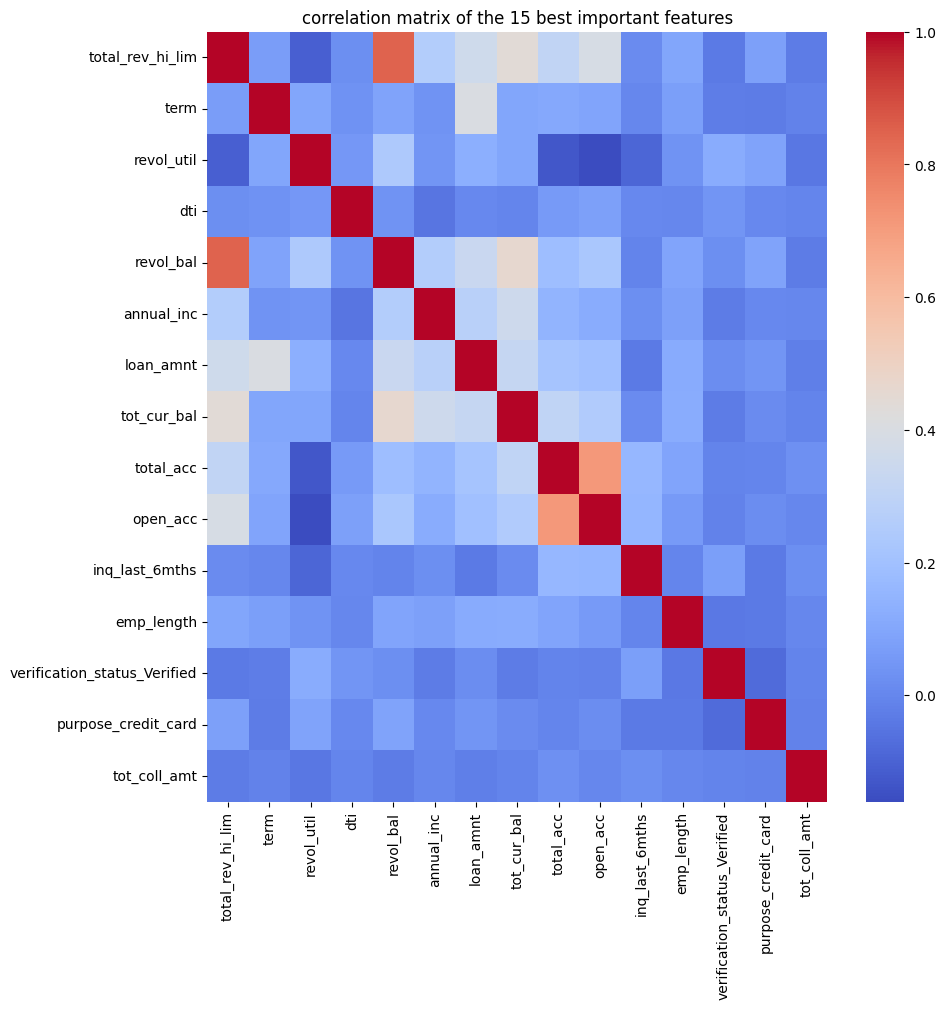

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("correlation matrix of the 15 best important features")
plt.show()

In [45]:
import pandas as pd
import numpy as np

corr = df_top15.corr()
corr_no_self = corr.abs()


np.fill_diagonal(corr_no_self.values, 0)

max_corr_info = corr_no_self.apply(
    lambda row: pd.Series([row.max(), row.idxmax()], index=["max_corr", "with_feature"])
)

max_corr_info

,total_rev_hi_lim,term,revol_util,dti,revol_bal,annual_inc,loan_amnt,tot_cur_bal,total_acc,open_acc,inq_last_6mths,emp_length,verification_status_Verified,purpose_credit_card,tot_coll_amt
max_corr,0.846547,0.401795,0.23923,0.076897,0.846547,0.355202,0.401795,0.464814,0.712439,0.712439,0.158727,0.118021,0.119282,0.086614,0.04499
with_feature,revol_bal,loan_amnt,revol_bal,open_acc,total_rev_hi_lim,tot_cur_bal,term,revol_bal,open_acc,total_acc,total_acc,tot_cur_bal,revol_util,revol_util,revol_util


From the correlation matrix, the tables, the heatmap we can observe that some pairs of variables exhibit moderate to high correlation, such as total_rev_hi_lim with revol_bal and total_acc with open_acc. However, the majority of features have low correlation between them, suggesting that the variables provide different and independent information to the model.
There is no level of correlation that causes serious multicollinearity, so the features can be safely used in the classification process.

We dropped some features with correlation and we will retrain the rf.

In [46]:
low_corr_features = [
    "revol_bal",
    "total_acc",
    "loan_amnt",
    "term",
    "revol_util",
    "dti",
    "annual_inc",
    "tot_cur_bal",
    "inq_last_6mths",
    "emp_length",
    "verification_status_Verified",
    "purpose_credit_card",
    "tot_coll_amt"
]

X_low = df[low_corr_features]
y_low = df["target"]

from sklearn.model_selection import train_test_split

X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(
    X_low, y_low, test_size=0.3, random_state=42, stratify=y_low)

from sklearn.ensemble import RandomForestClassifier

rf_low = RandomForestClassifier(random_state=42)
rf_low.fit(X_low_train, y_low_train)

RandomForestClassifier(random_state=42)

In [47]:
import pandas as pd

importances_low = rf_low.feature_importances_

feat_imp_low = pd.DataFrame({
    "feature": low_corr_features,
    "importance": importances_low
}).sort_values(by="importance", ascending=False)

feat_imp_low

,feature,importance
4,revol_util,0.143166
0,revol_bal,0.116537
5,dti,0.106673
3,term,0.099994
6,annual_inc,0.099787
7,tot_cur_bal,0.099710
2,loan_amnt,0.089372
1,total_acc,0.076424
9,emp_length,0.042736
8,inq_last_6mths,0.039746


In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_low_pred = rf_low.predict(X_low_test)

print("accuracy is:", accuracy_score(y_low_test, y_low_pred))
print("precision is:", precision_score(y_low_test, y_low_pred))
print("recall is:", recall_score(y_low_test, y_low_pred))
print("f1 is:", f1_score(y_low_test, y_low_pred))

accuracy is: 0.8057120500782473
precision is: 0.7082577765378714
recall is: 0.5522923804862131
f1 is: 0.6206264323911382


As we see from above, now, from the 15 most important feautures the revol_util, revol_bal, term, dti, and annual_inc are the top ones, which are key indicators of economic behavior and risk.





We also checked the metrics and we saw that the precision, recall and f1 have dropped. This is expected due to the removal of highly correlated variables that contained additional information.
Nevertheless, the model remains stable, simpler, and now less sensitive to multicollinearity.

# Part 5

This part is about dimensional reductions, and has nothing to do with the bank loans predictions.

In [49]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [50]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We uploaded the MNIST dataset from the Keras library and converted the 28x28 digit images into vectors of length 784 features.
Then, we did standard scaling (z-score) so that each feature was converted to a value with a zero mean and a unit standard deviation.
We did this, so the machine learning models will converge faster and will not be affected by scale differences.

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

ks = [5, 15, 51, 101]
accuracies = {}

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    preds = knn.predict(X_test_pca)
    acc = accuracy_score(y_test, preds)
    accuracies[k] = acc
    print(f"K = {k}, accuracy is = {acc}")

K = 5, accuracy is = 0.9497
K = 15, accuracy is = 0.9436
K = 51, accuracy is = 0.9273
K = 101, accuracy is = 0.9158


PCA was applied with 300 components and only on the training set (fit_transform), while only the transform was applied to the test set.
We did this because if it were fitted to the test set or if it were fitted to both the train and test sets, we would have data leakage and PCA would learn information that it is not allowed to know when evaluating the model. So it would destroy our model.
Moreover, regarding the KNN, if PCA fit was performed separately on the train and test sets, then the PCA axes would be different in the two sets and the KNN classifier would not be able to operate in a common feature space.

About the KNN classifier we trained with different values of k (5, 15, 51, and 101), the highest accuracy rate was achieved for k = 5 (94.97%). Performance decreases as k increases.
This is because small values of k allow for a more detailed separation of digits, while larger k values excessively smooth the decision boundary and lead to information loss.
Therefore, k=5 is the best choice for this particular data transformation.

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)

X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

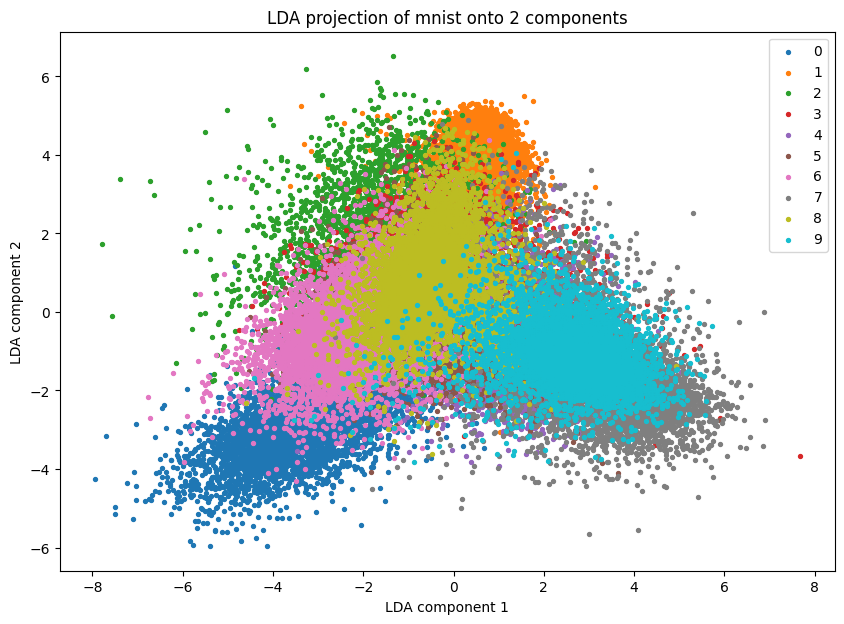

In [55]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,7))

for digit in range(10):
    idx = np.where(y_train == digit)
    plt.scatter(X_train_lda[idx, 0], X_train_lda[idx, 1], s=8, label=str(digit))

plt.legend()
plt.title("LDA projection of mnist onto 2 components")
plt.xlabel("LDA component 1")
plt.ylabel("LDA component 2")
plt.show()

From above, we see that the scatter plot of LDA in 2 dimensions shows that some classes, such as digits 0, 1, and 7, form relatively clear clusters, while others show significant overlap.
This suggests that MNIST data cannot be completely separated in two dimensions.
The loss of information due to the drastic reduction in dimensions (from 784 to 2) leads to overlap between digits with similar shapes.

Now trying the U-MAP method.

In [56]:
!pip install umap-learn

In [57]:
import umap

In [58]:
umap_model = umap.UMAP(n_components=2, random_state=42)

X_train_umap = umap_model.fit_transform(X_train_scaled)
X_test_umap = umap_model.transform(X_test_scaled)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


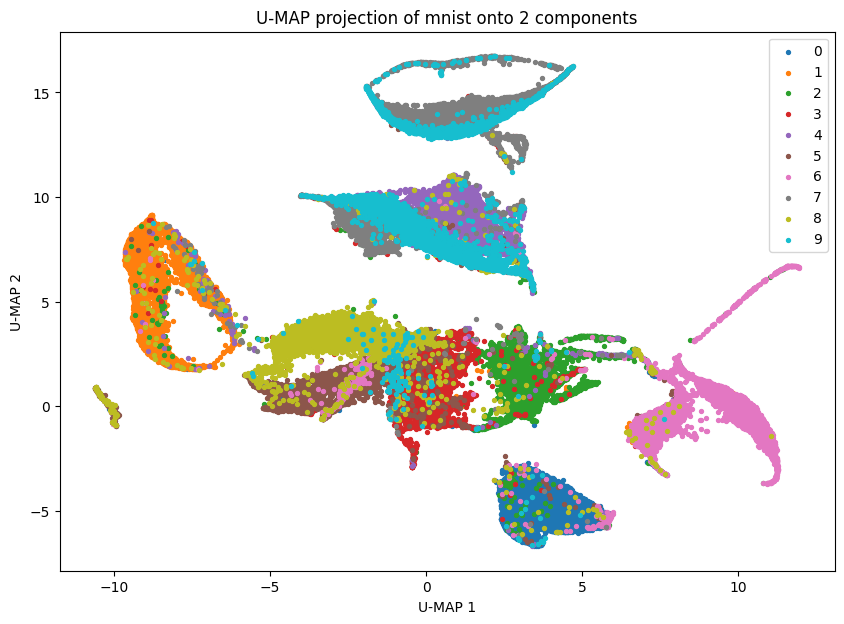

In [59]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,7))

for digit in range(10):
    idx = np.where(y_train == digit)[0]
    plt.scatter(X_train_umap[idx, 0], X_train_umap[idx, 1], s=8, label=str(digit))

plt.legend()
plt.title("U-MAP projection of mnist onto 2 components")
plt.xlabel("U-MAP 1")
plt.ylabel("U-MAP 2")
plt.show()

The U-MAP projection of mnist data in two dimensions shows significantly better class separation than LDA.
We observe that most digits form well defined and separate clusters. For example, digits 1, 0, 6, and 7 appear as compact and clearly separated areas in the diagram.
In contrast, in LDA, the digits were all located in one large area with significant overlap between classes.
UMAP aims to reduce the dimensionality of data while preserving its topological structure. It is particularly useful for visualizing high-dimensional datasets in a low-dimensional space, typically two or three dimensions.